## Malaria classifiation using CNN and data augumentation


![](./img/malaria_parasite.jpg)


### Objective:
The aim of this project is to distingulish if a person was infeacted with the Malaria from a microscopic image, and provide support for the lab examination results to quickly diagnosis the Malaria parasites.


## Malaria
Malaria is caused by Plasmodium parasites. The parasites are spread to people through the bites of infected female Anopheles mosquitoes, called "malaria vectors." 

Generally, the first symptoms of Malaria is fever, headache, and chills, but these symptoms usually appear after 10-15 days after the infective mosquito bite. 

In addition, the symptoms can be mild or severe and different for children and adult, which make it very difficult to recognize the malaria. **For example**, children with severe malaria frequently develop one or more of the following symptoms: severe anaemia, respiratory distress in relation to metabolic acidosis, or cerebral malaria. In adults, multi-organ failure is also frequent. In malaria endemic areas, people may develop partial immunity, allowing asymptomatic infections to occur.


### Diagnosis of Malaria can be difficult

1 Where malaria is not endemic any more (such as in the United States), health-care providers may not be familiar with the disease. Clinicians seeing a malaria patient may forget to consider malaria among the potential diagnoses and not order the needed diagnostic tests. Laboratorians may lack experience with malaria and fail to detect parasites when examining blood smears under the microscope.

2 In some malaria-endemic areas, malaria transmission is so intense that a large proportion of the population is infected but not made ill by the parasites. Such carriers have developed just enough immunity to protect them from malarial illness but not from malarial infection. In that situation, finding malaria parasites in an ill person does not necessarily mean that the illness is caused by the parasites.

There are multiple ways to diagnosis the Malaria parasites, such as Clinical diagnosis, Microscopic Diagnosis, Antigen detection, Molecular diagnosis,Serology and Drug resistance tests. 

**Thus, to develop a automated and robust system to diagnosis the Malaria parasites is emergent and can speed up the traditional way of malaria parasite diagnosis. In this project, we focus on approach named the Microscopic Diagnosis.**

### Microscopic Diagnosis

Microscopic Diagnosis is to identify the Malaria parasites by examining under the microscope a drop of the patient’s blood, spread out as a “blood smear” on a microscope slide. Prior to examination, the specimen is stained to give the parasites a distinctive appearance. This technique remains the gold standard for laboratory confirmation of malaria. However, it depends on the quality of the reagents, of the microscope, and on the experience of the laboratorian.


## Data
The data was obtained from [kaggle](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria). Originally, the data was taken from the official [NIH Website](https://ceb.nlm.nih.gov/repositories/malaria-datasets/).

There are two folders which contained the infected and uninfected malaria microscopic images.

## Method summary

    1 Download data

    2 Data exploration

    3 Data prepraration

    4 Data split into train, validate and test data sets

    5 Model building and evaluation: original data and data augumentation

**Note**: I used my local computer to run this anlysis which took a long time to run, maybe changed to a better computer resources such as Google Colab could save time.

## References
CDC [Microscopic Diagnosis](https://www.cdc.gov/malaria/diagnosis_treatment/diagnostic_tools.html#tabs-1-1)

WHO [Malaria](https://www.who.int/news-room/fact-sheets/detail/malaria)

Malaria Cell Atlas: mapping a murderous parasite’s [life cycle](https://sangerinstitute.blog/2019/08/22/malaria-cell-atlas-mapping-a-murderous-parasites-life-cycle/)

In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras import backend as K

import cv2
import random
from pathlib import Path
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from keras.utils import np_utils
from keras import optimizers

In [2]:
inpath1 = './data/cell_images/Parasitized/'
inpath0 = './data/cell_images/Uninfected/'

In [3]:
images1 = os.listdir(inpath1)
images0 = os.listdir(inpath0)

In [4]:
len(images1), len(images0)

(13780, 13780)

## Randomly show the figures

In [5]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML
from tensorflow.keras.applications.mobilenet import decode_predictions

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3



def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img

In [8]:
## radomly select five for each category
sel_ind = np.random.choice(len(images0),5)
names = ["Parasitized", "Uninfected"]*5
names = sorted(names)
SHAPE = (128,128)

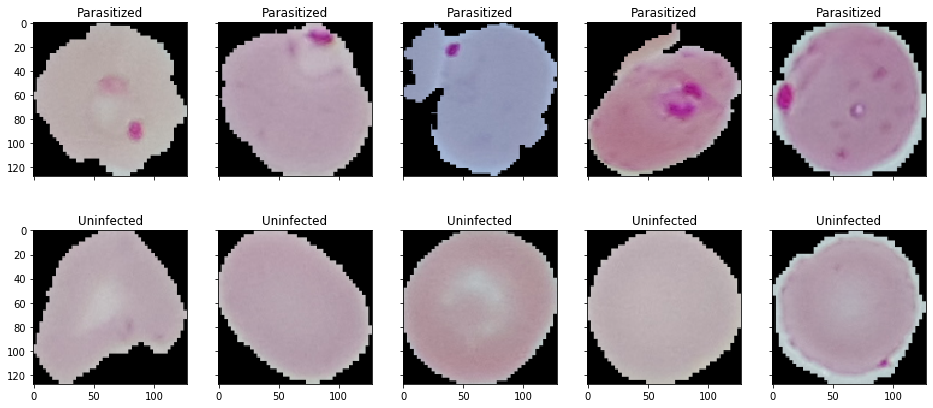

In [9]:
f, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize = (16,7))
ii=0

img_files = [inpath1 + images1[jj] for jj in sel_ind ] + [inpath0 + images0[jj] for jj in sel_ind]

for ax,name in zip(axes.ravel(),names):
    
    img2 = cv2.imread(img_files[ii])
    img2 = cv2.resize(img2, SHAPE)
    ii +=1
    ax.imshow(img2)
    ax.set_title(name)

### Single image will show different height and width
We need to resize the image before we process them

In [13]:
img2 = cv2.imread(inpath1 + images1[sel_ind[0]])

In [14]:
img2.shape

(133, 139, 3)

In [15]:
img2[:,:,2].max()

204

## Prepare data for model (take a while to build the dataset)

In [16]:

SHAPE = (128, 128)
batch_size = 32

data = []
labels = []
for img in images1:
    try:
        img_read = plt.imread(inpath1 + img)
        img_resize = cv2.resize(img_read, SHAPE)
        #img_array = img_to_array(img_resize)
        #data.append(img_array)
        data.append(img_resize)
        labels.append(1)
    except:
        None
        
for img in images0:
    try:
        img_read = plt.imread(inpath0 + img)
        img_resize = cv2.resize(img_read, SHAPE)
        #img_array = img_to_array(img_resize)
        #data.append(img_array)
        data.append(img_resize)
        labels.append(0)
    except:
        None

## Train and test split

In [17]:
image_data = np.array(data)
labels = np.array(labels)

In [18]:
## Shuffle the data
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test1, y_train, y_test1 = train_test_split(image_data, labels, test_size = 0.3, random_state = 90)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size = 0.5, random_state = 90)


y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)
y_val = np_utils.to_categorical(y_val, num_classes = 2)

In [20]:
print(f'SHAPE OF TRAINING IMAGE DATA : {x_train.shape}')
print(f'SHAPE OF TESTING IMAGE DATA : {x_test.shape}')
print(f'SHAPE OF TRAINING LABELS : {y_train.shape}')
print(f'SHAPE OF TESTING LABELS : {y_test.shape}')
print(f'SHAPE OF validation LABELS : {y_val.shape}')

SHAPE OF TRAINING IMAGE DATA : (19290, 128, 128, 3)
SHAPE OF TESTING IMAGE DATA : (4134, 128, 128, 3)
SHAPE OF TRAINING LABELS : (19290, 2)
SHAPE OF TESTING LABELS : (4134, 2)
SHAPE OF validation LABELS : (4134, 2)


## Model - original data

In [37]:
### Define model structure ###

def get_model():
    
    inp = Input(shape=SHAPE+tuple([3]))

    x = Conv2D(32, (3, 3), activation='relu')(inp)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x, training = True)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x, training = True)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x, training = True)

    out = Dense(2, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #optim = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
    #model.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])
    
    return model

In [25]:

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)

model = get_model()
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 30, 32)        128 

In [26]:
model.fit(x_train, y_train, 
          epochs = 50, batch_size = batch_size,
          validation_data = (x_val,y_val),
          callbacks=[es],
          verbose = 1)

Train on 19290 samples, validate on 4134 samples
Epoch 1/50
19290/19290 [==============================] - 2359s 122ms/sample - loss: 0.5172 - accuracy: 0.7846 - val_loss: 0.3031 - val_accuracy: 0.8824
Epoch 2/50
19290/19290 [==============================] - 2512s 130ms/sample - loss: 0.1855 - accuracy: 0.9395 - val_loss: 0.1907 - val_accuracy: 0.9446
Epoch 3/50
19290/19290 [==============================] - 2378s 123ms/sample - loss: 0.1657 - accuracy: 0.9461 - val_loss: 0.1765 - val_accuracy: 0.9403
Epoch 4/50
19290/19290 [==============================] - 1986s 103ms/sample - loss: 0.1501 - accuracy: 0.9506 - val_loss: 0.1838 - val_accuracy: 0.9497
Epoch 5/50
19290/19290 [==============================] - 1972s 102ms/sample - loss: 0.1526 - accuracy: 0.9504 - val_loss: 0.1772 - val_accuracy: 0.9523
Epoch 6/50
19290/19290 [==============================] - 1944s 101ms/sample - loss: 0.1338 - accuracy: 0.9568 - val_loss: 0.1797 - val_accuracy: 0.9412
Epoch 7/50
19290/19290 [=========

In [27]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.1719794693593536
Test accuracy: 0.958635687828064


# Data augumentation

In [28]:
train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  #zoom_range = 0.3,
                                  rotation_range = 30)
val_datagen = ImageDataGenerator(rescale = 1/255.)

In [33]:
batch_size = 32
train_generator = train_datagen.flow(x_train, y_train, batch_size = batch_size, shuffle = True)
val_generator = val_datagen.flow(x_val, y_val, batch_size = batch_size, shuffle = True)
test_generator = val_datagen.flow(x_test, y_test, batch_size = batch_size, shuffle = True)

## Model - data augumentation

In [38]:
model_aug = get_model()

In [39]:
hist_aug = model_aug.fit_generator(train_generator, 
                               steps_per_epoch= len(x_train) // batch_size,
                               epochs=50, 
                               validation_data=val_generator, 
                               validation_steps = len(x_val) // batch_size, 
                               callbacks=[es], verbose = 1)

Epoch 1/50
602/602 [==============================] - 2546s 4s/step - loss: 0.7218 - accuracy: 0.6549 - val_loss: 1.6784 - val_accuracy: 0.5017
Epoch 2/50
602/602 [==============================] - 2532s 4s/step - loss: 0.3383 - accuracy: 0.8687 - val_loss: 0.2152 - val_accuracy: 0.9406
Epoch 3/50
602/602 [==============================] - 2523s 4s/step - loss: 0.2962 - accuracy: 0.8927 - val_loss: 0.3093 - val_accuracy: 0.9319
Epoch 4/50
602/602 [==============================] - 2529s 4s/step - loss: 0.2830 - accuracy: 0.9048 - val_loss: 0.1907 - val_accuracy: 0.9426
Epoch 5/50
602/602 [==============================] - 2526s 4s/step - loss: 0.2670 - accuracy: 0.9078 - val_loss: 0.2362 - val_accuracy: 0.9220
Epoch 6/50
602/602 [==============================] - 2527s 4s/step - loss: 0.2600 - accuracy: 0.9134 - val_loss: 0.5016 - val_accuracy: 0.8430
Epoch 7/50
602/602 [==============================] - 2526s 4s/step - loss: 0.2555 - accuracy: 0.9134 - val_loss: 0.2376 - val_accuracy:

In [42]:
#evaluate the model on augmented test data
score_aug = model_aug.evaluate_generator(test_generator, steps = 5)

In [43]:
print('Test loss: {}'.format(score_aug[0]))
print('Test accuracy: {}'.format(score_aug[1]))

Test loss: 0.15820900797843934
Test accuracy: 0.949999988079071


## Visualization

In [57]:
### AUGMENT 4 TIMES EVERY SINGLE IMAGE for test###
rep=4
#validation_num = val_generator.samples
image_test, label_test = [], []
'''what does this do is to generate the image using original images.
each time it will select 32 images to conduct data augmentation, if the number of left images is larger than 32, 
otherwise it will use the left.
The replication will tell how many times of data augmentation for each image
'''
for i, (batch, label) in enumerate(test_generator):
    
    image_test.append(batch)
    label_test.append(label)
        
    if i == ((len(x_test) // batch_size)+1)*rep-1:
        break
        

In [58]:
image_test = np.vstack(image_test)

label_test = np.argmax(np.vstack(label_test), axis=1) ## for multiple class
#label_test = np.hstack(label_test) ## for two class

print(image_test.shape, label_test.shape)

(16536, 128, 128, 3) (16536,)


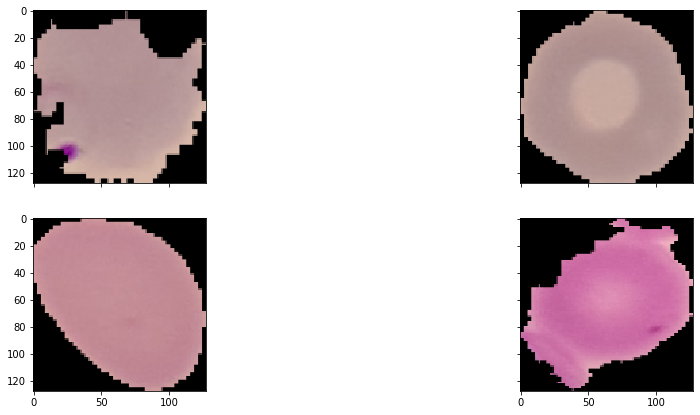

In [73]:
test_num = len(x_test)
random_id = np.random.randint(0, test_num)
img_ids = np.arange(random_id, image_test.shape[0], test_num)

f, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (16,7))
for ax, img_id in zip(axes.ravel(), img_ids):
    ax.imshow(image_test[img_id]*255)


## Evaulation - confusion matrix

### Used augumented data

In [74]:
### COMPUTE PREDICTIONS ###

pred_prob_test2 = model_aug.predict(image_test)
pred_test_aug = np.argmax(pred_prob_test2, axis=1)


In [78]:
pred_prob_test1 = model.predict(image_test)
pred_test_ori = np.argmax(pred_prob_test1, axis=1)

In [77]:
## data augumentation
print(classification_report(label_test,pred_test_aug,target_names = ['Parasited','Uninfected']))

              precision    recall  f1-score   support

   Parasited       0.96      0.96      0.96      8452
  Uninfected       0.96      0.96      0.96      8084

    accuracy                           0.96     16536
   macro avg       0.96      0.96      0.96     16536
weighted avg       0.96      0.96      0.96     16536



In [79]:
## original data
print(classification_report(label_test,pred_test_ori,target_names = ['Parasited','Uninfected']))

              precision    recall  f1-score   support

   Parasited       0.51      0.95      0.67      8452
  Uninfected       0.49      0.05      0.09      8084

    accuracy                           0.51     16536
   macro avg       0.50      0.50      0.38     16536
weighted avg       0.50      0.51      0.38     16536



### Used original data

In [86]:
## data aug model
pred_prob_test2_ori = model_aug.predict(x_test)
pred_test_aug_ori = np.argmax(pred_prob_test2_ori, axis=1)

In [87]:
label_true = np.argmax(y_test, axis=1)
print(classification_report(label_true,pred_test_aug_ori,target_names = ['Parasited','Uninfected']))

              precision    recall  f1-score   support

   Parasited       0.54      0.46      0.50      2113
  Uninfected       0.51      0.60      0.55      2021

    accuracy                           0.53      4134
   macro avg       0.53      0.53      0.53      4134
weighted avg       0.53      0.53      0.53      4134



In [88]:
## original data model
pred_prob_test1_ori = model.predict(x_test)
pred_test_ori_ori = np.argmax(pred_prob_test1_ori, axis=1)
print(classification_report(label_true,pred_test_ori_ori,target_names = ['Parasited','Uninfected']))

              precision    recall  f1-score   support

   Parasited       0.95      0.96      0.96      2113
  Uninfected       0.96      0.94      0.95      2021

    accuracy                           0.95      4134
   macro avg       0.95      0.95      0.95      4134
weighted avg       0.95      0.95      0.95      4134

